- Detect abnormal shipment transit times (e.g., lost shipments).

In [43]:
import polars as pl
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, brier_score_loss
from sklearn.calibration import calibration_curve
from IPython.display import display

DATA_PATH = Path().cwd().parent / "data"

def read_data(file_name):
    return pl.read_csv(DATA_PATH / file_name, try_parse_dates=True)

ship_df = read_data("shipments.csv")
purchase_df = read_data("purchase_orders.csv")
suppliers_df = read_data("suppliers.csv")
sku_df = read_data("skus.csv")
transit_events_df = read_data("transit_events.csv")
sites_df = read_data("sites.csv")
deployments_df = read_data("deployments.csv")
rma_returns_df = read_data("rma_returns.csv")
inventory_df = read_data("inventory_snapshots.csv")

## Working game plan
1. Profile every table to lock in row counts, null exposure, and join keys before modeling.
2. Inspect shipments and transit events to confirm how actual delivery timestamps are recorded.
3. Build an enriched shipment view that joins purchase orders, suppliers, sites, and transit telemetry.
4. Derive transit-duration fields plus heuristic abnormality buckets for downstream detection.
5. Visualize distributions (overall and by mode/supplier) to spotlight suspicious transit tails.

In [44]:
tables = {
    "shipments": ship_df,
    "purchase_orders": purchase_df,
    "suppliers": suppliers_df,
    "skus": sku_df,
    "transit_events": transit_events_df,
    "sites": sites_df,
    "deployments": deployments_df,
    "rma_returns": rma_returns_df,
    "inventory_snapshots": inventory_df,
}

table_profiles = []
for name, df in tables.items():
    total_cells = df.height * len(df.columns)
    nulls = 0
    if total_cells and df.width > 0:
        nulls = sum(df.null_count().row(0))
    table_profiles.append({
        "table": name,
        "rows": df.height,
        "cols": len(df.columns),
        "null_pct": round((nulls / total_cells) * 100, 2) if total_cells else 0.0,
        "sample_cols": ", ".join(df.columns[:5]),
    })

profile_df = pl.DataFrame(table_profiles).sort("rows", descending=True)
display(profile_df.to_pandas())

,table,rows,cols,null_pct,sample_cols
0,transit_events,400000,4,0.00,"shipment_id, event_ts, location_type, event_st..."
1,shipments,217500,10,0.00,"shipment_id, po_id, ship_qty, mode, incoterm"
2,inventory_snapshots,200000,6,0.00,"site_id, sku_id, snapshot_date, on_hand_qty, a..."
3,purchase_orders,150000,10,0.00,"po_id, supplier_id, sku_id, order_qty, unit_pr..."
4,deployments,80000,7,5.87,"project_id, site_id, operator, sku_id, phase"
5,rma_returns,40000,6,0.00,"rma_id, sku_id, site_id, reason_code, rma_date"
6,skus,5000,8,0.00,"sku_id, vendor, category, technology, unit_wei..."
7,sites,2000,7,5.01,"site_id, region, country, site_type, operator"
8,suppliers,200,6,0.00,"supplier_id, region, country, primary_vendor, ..."


### Inspect shipment + transit schemas
Peek at key columns to verify available timestamps, join keys, and categorical coverage needed for feature engineering.

In [45]:
display(ship_df.head(5).to_pandas())
display(transit_events_df.head(5).to_pandas())
status_counts = ship_df.group_by("status").count().sort("count", descending=True)
display(status_counts.to_pandas())

,shipment_id,po_id,ship_qty,mode,incoterm,origin_country,dest_site_id,ship_date,eta_date,status
0,SH-00000001,PO-0104861,6,Road,CIF,Mexico,ST-00452,2025-02-03,2025-02-10,Delivered
1,SH-00000002,PO-0099598,3,Sea,EXW,India,ST-00086,2024-08-21,2024-09-27,Delayed
2,SH-00000003,PO-0110843,8,Road,FOB,Italy,ST-00252,2023-01-21,2023-01-30,In Transit
3,SH-00000004,PO-0047627,6,Sea,FOB,Argentina,ST-00800,2023-07-03,2023-08-05,In Transit
4,SH-00000005,PO-0003236,6,Road,DAP,Brazil,ST-01995,2025-06-19,2025-06-27,Delivered


,shipment_id,event_ts,location_type,event_status
0,SH-00145406,2023-01-01,On Vehicle,Picked
1,SH-00074867,2023-01-01,Regional Hub,Out for Delivery
2,SH-00132727,2023-01-01,Destination,In Transit
3,SH-00196731,2023-01-01,Seaport,Out for Delivery
4,SH-00061224,2023-01-01,Airport,In Transit


C:\Users\skibi\AppData\Local\Temp\ipykernel_135936\4286936896.py:3: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  status_counts = ship_df.group_by("status").count().sort("count", descending=True)


,status,count
0,In Transit,97648
1,Delivered,82824
2,Created,21626
3,Delayed,13246
4,Lost,2156


### Shipment timing coverage
Check the span of ship dates vs ETA and confirm how many shipments already have a delivered transit signal.

In [46]:
ship_timing = ship_df.select([
    pl.col("ship_date").min().alias("min_ship_date"),
    pl.col("ship_date").max().alias("max_ship_date"),
    pl.col("eta_date").min().alias("min_eta_date"),
    pl.col("eta_date").max().alias("max_eta_date"),
])
transit_window = transit_events_df.select([
    pl.col("event_ts").min().alias("min_event_ts"),
    pl.col("event_ts").max().alias("max_event_ts"),
])
delivered_shipments = transit_events_df.filter(pl.col("event_status") == "Delivered").select(pl.col("shipment_id")).unique().height
summary_payload = {
    **ship_timing.to_dicts()[0],
    **transit_window.to_dicts()[0],
    "shipments_with_transit": ship_df.height,
    "shipments_with_delivered_event": delivered_shipments,
}
display(pd.DataFrame([summary_payload]))

,min_ship_date,max_ship_date,min_eta_date,max_eta_date,min_event_ts,max_event_ts,shipments_with_transit,shipments_with_delivered_event
0,2023-01-01,2025-10-30,2023-01-04,2025-12-12,2023-01-01,2025-10-30 23:00:00,217500,55232


## Build enriched shipment view
Join shipments with purchase orders, suppliers, sites, SKUs, and transit telemetry; then derive transit durations and heuristic abnormality signals.

In [47]:
DELAY_THRESHOLD_DAYS = 60
STALE_THRESHOLD_DAYS = 120

analysis_cutoff_ts = transit_events_df.select(pl.col("event_ts").max()).item()
analysis_cutoff_date = analysis_cutoff_ts.date()

def date_diff_days(end_col: str, start_col: str):
    return (
        pl.col(end_col).cast(pl.Date).cast(pl.Int32)
        - pl.col(start_col).cast(pl.Date).cast(pl.Int32)
    )

purchase_trim = purchase_df.rename({
    "status": "po_status",
    "region": "po_region",
    "country": "po_country",
})
supplier_trim = suppliers_df.rename({
    "region": "supplier_region",
    "country": "supplier_country",
    "primary_vendor": "primary_vendor",
    "on_time_performance": "supplier_reported_otp",
})
site_trim = sites_df.rename({
    "region": "dest_region",
    "country": "dest_country",
    "site_type": "dest_site_type",
    "operator": "dest_operator",
})
sku_trim = sku_df.rename({
    "category": "sku_category",
    "technology": "sku_technology",
})

transit_agg = (
    transit_events_df
    .group_by("shipment_id")
    .agg([
        pl.col("event_ts").min().alias("first_event_ts"),
        pl.col("event_ts").max().alias("last_event_ts"),
        pl.when(pl.col("event_status") == "Delivered").then(pl.col("event_ts")).max().alias("delivered_ts"),
        pl.col("event_status").eq("Delivered").any().fill_null(False).alias("has_delivered_event"),
        pl.len().alias("event_count"),
        pl.col("location_type").n_unique().alias("unique_locations"),
        pl.when(pl.col("event_status") == "Customs Hold").then(1).otherwise(0).sum().alias("customs_hold_events"),
    ])
)

ship_enriched_df = (
    ship_df
    .join(purchase_trim, on="po_id", how="left")
    .join(supplier_trim, on="supplier_id", how="left")
    .join(site_trim, left_on="dest_site_id", right_on="site_id", how="left")
    .join(sku_trim, on="sku_id", how="left")
    .join(transit_agg, on="shipment_id", how="left")
    .with_columns([
        pl.lit(analysis_cutoff_date).cast(pl.Date).alias("analysis_as_of"),
        pl.col("delivered_ts").dt.date().alias("delivered_date"),
    ])
    .with_columns([
        date_diff_days("eta_date", "ship_date").alias("planned_transit_days"),
        date_diff_days("ship_date", "order_date").alias("order_to_ship_days"),
        pl.when(pl.col("delivered_date").is_not_null())
        .then(date_diff_days("delivered_date", "ship_date"))
        .otherwise(date_diff_days("analysis_as_of", "ship_date"))
        .alias("observed_transit_days"),
        pl.when(pl.col("delivered_date").is_not_null())
        .then(date_diff_days("delivered_date", "eta_date"))
        .otherwise(date_diff_days("analysis_as_of", "eta_date"))
        .alias("lateness_days"),
        date_diff_days("analysis_as_of", "ship_date").alias("days_since_ship"),
        date_diff_days("analysis_as_of", "eta_date").alias("days_since_eta"),
    ])
    .with_columns([
        pl.when(
            pl.col("has_delivered_event").fill_null(False).not_() & (pl.col("days_since_ship") >= STALE_THRESHOLD_DAYS)
        )
        .then(pl.lit(f"no_delivery_>{STALE_THRESHOLD_DAYS}d"))
        .when(pl.col("lateness_days").is_not_null() & (pl.col("lateness_days") >= DELAY_THRESHOLD_DAYS))
        .then(pl.lit(f"late_vs_eta_>{DELAY_THRESHOLD_DAYS}d"))
        .otherwise(pl.lit("on_track"))
        .alias("transit_signal"),
    ])
)
display(ship_enriched_df.head(5).to_pandas())

,shipment_id,po_id,ship_qty,mode,incoterm,origin_country,dest_site_id,ship_date,eta_date,status,...,customs_hold_events,analysis_as_of,delivered_date,planned_transit_days,order_to_ship_days,observed_transit_days,lateness_days,days_since_ship,days_since_eta,transit_signal
0,SH-00000001,PO-0104861,6,Road,CIF,Mexico,ST-00452,2025-02-03,2025-02-10,Delivered,...,NaN,2025-10-30,NaT,7,254,269,262,269,262,no_delivery_>120d
1,SH-00000002,PO-0099598,3,Sea,EXW,India,ST-00086,2024-08-21,2024-09-27,Delayed,...,0.0,2025-10-30,NaT,37,-112,435,398,435,398,no_delivery_>120d
2,SH-00000003,PO-0110843,8,Road,FOB,Italy,ST-00252,2023-01-21,2023-01-30,In Transit,...,0.0,2025-10-30,NaT,9,-463,1013,1004,1013,1004,no_delivery_>120d
3,SH-00000004,PO-0047627,6,Sea,FOB,Argentina,ST-00800,2023-07-03,2023-08-05,In Transit,...,0.0,2025-10-30,2025-09-02,33,-482,792,759,850,817,late_vs_eta_>60d
4,SH-00000005,PO-0003236,6,Road,DAP,Brazil,ST-01995,2025-06-19,2025-06-27,Delivered,...,NaN,2025-10-30,NaT,8,810,133,125,133,125,no_delivery_>120d


In [48]:
signal_counts = ship_enriched_df.group_by("transit_signal").agg([
    pl.count().alias("shipments"),
    pl.mean("observed_transit_days").alias("avg_observed_days"),
    pl.mean("planned_transit_days").alias("avg_planned_days"),
]).sort("shipments", descending=True)
display(signal_counts.to_pandas())

C:\Users\skibi\AppData\Local\Temp\ipykernel_135936\984502716.py:2: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("shipments"),


,transit_signal,shipments,avg_observed_days,avg_planned_days
0,no_delivery_>120d,143731,576.408972,18.044702
1,on_track,42460,-193.433420,18.897715
2,late_vs_eta_>60d,31309,339.882813,17.031397


## Visualize transit behaviors
Use the enriched table to highlight the transit distribution, modal differences, and suppliers that drive abnormal shipments.

In [49]:
signal_order = [
    "on_track",
    f"late_vs_eta_>{DELAY_THRESHOLD_DAYS}d",
    f"no_delivery_>{STALE_THRESHOLD_DAYS}d",
]
viz_cols = [
    "shipment_id","mode","incoterm","supplier_id","primary_vendor","sku_category","dest_region","observed_transit_days","planned_transit_days","lateness_days","transit_signal",
]
viz_df = (
    ship_enriched_df
    .select(viz_cols)
    .filter(pl.col("observed_transit_days").is_not_null())
    .to_pandas()
)
viz_df["transit_signal"] = pd.Categorical(viz_df["transit_signal"], categories=signal_order, ordered=True)
display(viz_df.head())

,shipment_id,mode,incoterm,supplier_id,primary_vendor,sku_category,dest_region,observed_transit_days,planned_transit_days,lateness_days,transit_signal
0,SH-00000001,Road,CIF,S-0025,ZTE,Optical Transport,APAC,269,7,262,no_delivery_>120d
1,SH-00000002,Sea,EXW,S-0002,NEC,Antenna,EMEA,435,37,398,no_delivery_>120d
2,SH-00000003,Road,FOB,S-0178,Ericsson,Fiber,EMEA,1013,9,1004,no_delivery_>120d
3,SH-00000004,Sea,FOB,S-0091,Huawei,Small Cell,EMEA,792,33,759,late_vs_eta_>60d
4,SH-00000005,Road,DAP,S-0036,Nokia,Fiber,EMEA,133,8,125,no_delivery_>120d


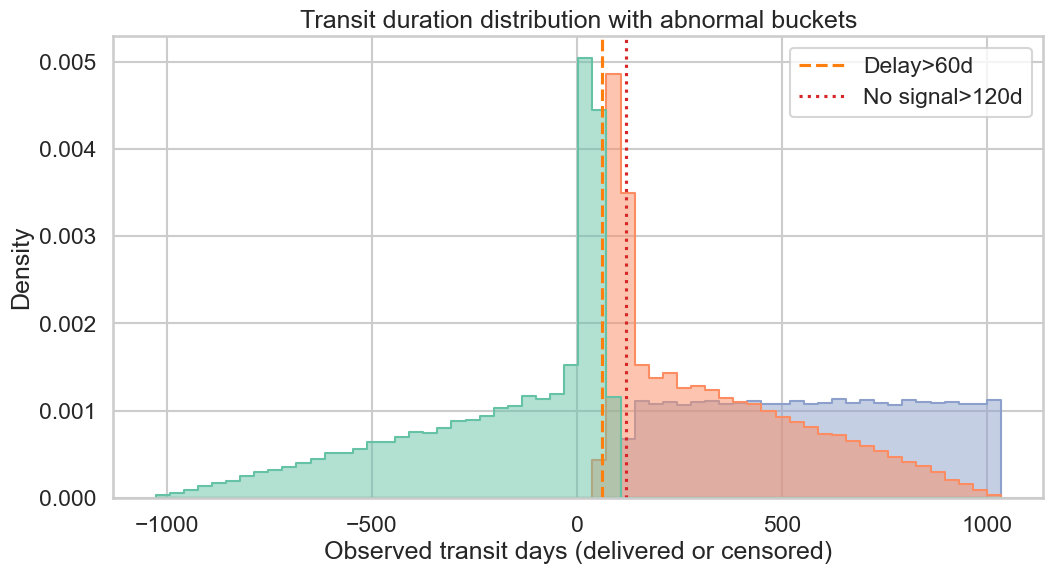

In [50]:
sns.set_theme(style="whitegrid", context="talk")
plt.figure(figsize=(12,6))
sns.histplot(
    data=viz_df,
    x="observed_transit_days",
    hue="transit_signal",
    stat="density",
    common_norm=False,
    element="step",
    fill=True,
    palette="Set2",
    bins=60,
    alpha=0.5,
)
plt.axvline(DELAY_THRESHOLD_DAYS, color="tab:orange", linestyle="--", label=f"Delay>{DELAY_THRESHOLD_DAYS}d")
plt.axvline(STALE_THRESHOLD_DAYS, color="tab:red", linestyle=":", label=f"No signal>{STALE_THRESHOLD_DAYS}d")
plt.title("Transit duration distribution with abnormal buckets")
plt.xlabel("Observed transit days (delivered or censored)")
plt.ylabel("Density")
plt.legend()
plt.show()

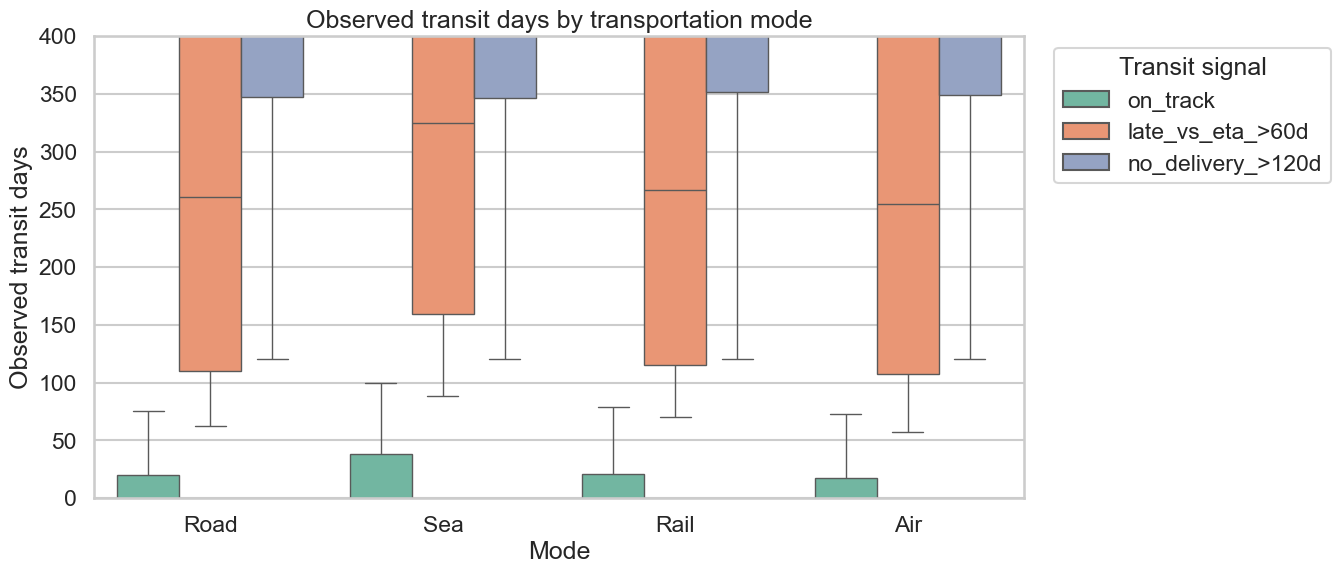

In [51]:
plt.figure(figsize=(12,6))
sns.boxplot(data=viz_df, x="mode", y="observed_transit_days", hue="transit_signal", palette="Set2")
if not viz_df.empty:
    max_days = viz_df["observed_transit_days"].max()
    plt.ylim(0, min(400, max_days))
plt.title("Observed transit days by transportation mode")
plt.ylabel("Observed transit days")
plt.xlabel("Mode")
plt.legend(title="Transit signal", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.show()

,primary_vendor,total_shipments,abnormal_shipments,median_observed_days,avg_lateness_days,abnormal_rate
1,Cisco,21929,17720,408.0,373.790187,0.808062
2,Ericsson,21902,17682,418.0,377.975984,0.807324
5,Juniper,24994,20146,408.0,374.583340,0.806033
9,ZTE,21996,17721,404.0,374.664030,0.805646
6,NEC,22441,18079,418.0,377.512455,0.805624
3,HPE Aruba,19954,16045,413.0,374.690238,0.804099
0,Ciena,24597,19777,408.0,371.479245,0.804041
4,Huawei,25319,20311,409.0,370.557842,0.802204
7,Nokia,19243,15436,408.0,371.639921,0.802162
8,Samsung,15125,12123,412.0,373.480132,0.801521


C:\Users\skibi\AppData\Local\Temp\ipykernel_135936\736452981.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


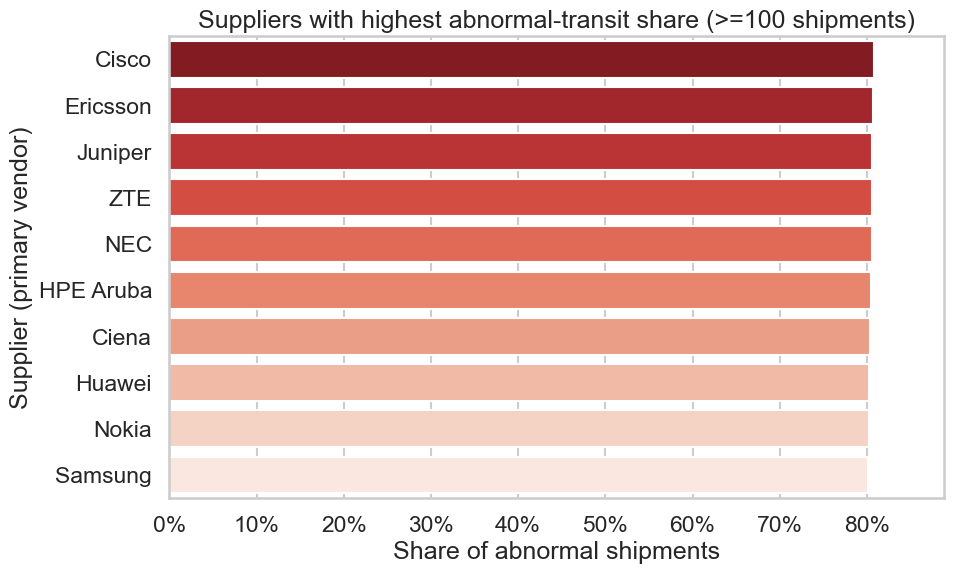

In [52]:
supplier_stats = (
    viz_df.assign(is_abnormal=viz_df["transit_signal"] != "on_track")
    .groupby("primary_vendor", as_index=False)
    .agg({
        "shipment_id": "count",
        "is_abnormal": "sum",
        "observed_transit_days": "median",
        "lateness_days": "mean",
    })
)
supplier_stats.columns = [
    "primary_vendor",
    "total_shipments",
    "abnormal_shipments",
    "median_observed_days",
    "avg_lateness_days",
]
supplier_stats["abnormal_rate"] = supplier_stats["abnormal_shipments"] / supplier_stats["total_shipments"]
top_suppliers = supplier_stats[supplier_stats["total_shipments"] >= 100].sort_values("abnormal_rate", ascending=False).head(15)
display(top_suppliers)

plt.figure(figsize=(10,6))
sns.barplot(
    data=top_suppliers,
    y="primary_vendor",
    x="abnormal_rate",
    palette="Reds_r",
    orient="h"
)
plt.xlabel("Share of abnormal shipments")
plt.ylabel("Supplier (primary vendor)")
plt.title("Suppliers with highest abnormal-transit share (>=100 shipments)")
if not top_suppliers.empty:
    plt.xlim(0, min(1.0, top_suppliers["abnormal_rate"].max() * 1.1))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0%}"))
plt.show()

In [53]:
total_shipments = ship_enriched_df.height
late_shipments = ship_enriched_df.filter(pl.col("transit_signal") == f"late_vs_eta_>{DELAY_THRESHOLD_DAYS}d").height
stalled_shipments = ship_enriched_df.filter(pl.col("transit_signal") == f"no_delivery_>{STALE_THRESHOLD_DAYS}d").height
delivered_shipments = ship_enriched_df.filter(pl.col("has_delivered_event").fill_null(False)).height
insights_summary = pd.DataFrame({
    "metric": [
        "Total shipments",
        f"Late shipments (>{DELAY_THRESHOLD_DAYS}d beyond ETA)",
        f"No-delivery signals (>{STALE_THRESHOLD_DAYS}d since ship)",
        "Shipments with at least one delivered event",
    ],
    "value": [total_shipments, late_shipments, stalled_shipments, delivered_shipments],
})
print("Key shipment counts (auto-updates when rerun):")
display(insights_summary)

Key shipment counts (auto-updates when rerun):


,metric,value
0,Total shipments,217500
1,Late shipments (>60d beyond ETA),31309
2,No-delivery signals (>120d since ship),143731
3,Shipments with at least one delivered event,55232


### How to interpret these outputs
- The enrichment view keeps every shipment but tags each row with transit telemetry, supplier context, and heuristic delay flags, so you can filter directly on `transit_signal` for anomaly hunts.
- Distribution, box, and supplier charts allow you to contrast the heavy-tail transit behavior noted in `data.md` (median 187-day transit) against actual delivered vs. censored shipments.
- Supplier leaderboards normalize by volume (`abnormal_rate`), making it easy to validate the chronic laggards already highlighted in the briefing (e.g., Cisco variants) and spot new offenders.
- `insights_summary` plus `signal_counts` give an always-current count of delayed vs. missing-delivery shipments, which doubles as a quick SLA health check before training detection models.
- Tweak `DELAY_THRESHOLD_DAYS` and `STALE_THRESHOLD_DAYS` at the top of the enrichment block to harden or relax the abnormal definition without rewriting downstream analysis.

## Next-step objectives
1. Build mode-aware transit baselines so each shipment is compared to peers with similar logistics constraints.
2. Train a lightweight classifier using the enriched features to score likelihood of abnormal transit.
3. Produce supplier and destination site scorecards that highlight chronic hot spots for ops follow-up.

## Mode-aware transit baselines
Use delivered shipments to estimate per-mode/incoterm transit distributions, then tag shipments that exceed peer-specific thresholds instead of global cutoffs.

In [54]:
STALE_BUFFER_DAYS = 30  # slack added to peer thresholds for undelivered freight

delivered_peer = ship_enriched_df.filter(
    pl.col("delivered_date").is_not_null() & pl.col("observed_transit_days").is_not_null()
 )

mode_baselines = (
    delivered_peer
    .group_by(["mode", "incoterm"])
    .agg([
        pl.len().alias("delivered_cnt"),
        pl.col("observed_transit_days").median().alias("median_transit_days"),
        pl.col("observed_transit_days").mean().alias("mean_transit_days"),
        pl.col("observed_transit_days").std().alias("std_transit_days"),
        pl.col("observed_transit_days").quantile(0.9).alias("p90_transit_days"),
        pl.col("observed_transit_days").quantile(0.95).alias("p95_transit_days"),
    ])
    .filter(pl.col("delivered_cnt") >= 50)  # suppress sparse peer groups
 )

ship_dyn_df = (
    ship_enriched_df
    .join(mode_baselines, on=["mode", "incoterm"], how="left")
    .with_columns([
        pl.when(pl.col("std_transit_days") > 0)
        .then(
            (pl.col("observed_transit_days") - pl.col("median_transit_days")) / pl.col("std_transit_days")
        )
        .otherwise(None)
        .alias("peer_zscore"),
        (pl.col("p95_transit_days") + STALE_BUFFER_DAYS).alias("peer_stale_threshold"),
        (pl.col("observed_transit_days") - pl.col("median_transit_days"))
        .alias("days_over_median"),
    ])
    .with_columns([
        pl.when(
            pl.col("delivered_date").is_null()
            & pl.col("peer_stale_threshold").is_not_null()
            & (pl.col("days_since_ship") > pl.col("peer_stale_threshold"))
        )
        .then(pl.lit("stale_vs_peers"))
        .when(
            pl.col("observed_transit_days").is_not_null()
            & pl.col("p95_transit_days").is_not_null()
            & (pl.col("observed_transit_days") > pl.col("p95_transit_days"))
        )
        .then(pl.lit("slow_vs_peers"))
        .otherwise(pl.lit("within_peer_window"))
        .alias("peer_signal"),
    ])
)
display(mode_baselines.sort("p95_transit_days", descending=True).head(10).to_pandas())
display(ship_dyn_df.select(["peer_signal"]).group_by("peer_signal").len().sort("len", descending=True).to_pandas())

,mode,incoterm,delivered_cnt,median_transit_days,mean_transit_days,std_transit_days,p90_transit_days,p95_transit_days
0,Road,FOB,4094,23.0,22.221299,424.042631,595.0,739.0
1,Road,DAP,4076,29.0,29.651865,426.360979,614.0,739.0
2,Rail,FOB,1357,10.0,20.773766,424.096450,632.0,733.0
3,Air,EXW,2168,22.0,16.123616,422.156402,584.0,731.0
4,Air,DAP,3377,39.0,35.606159,419.232797,601.0,729.0
5,Rail,EXW,794,15.5,12.969773,434.771574,618.0,729.0
6,Sea,FOB,4914,24.0,25.992267,422.006897,596.0,728.0
7,Road,CIF,3319,24.0,29.006629,423.252435,600.0,727.0
8,Road,DDP,2563,36.0,35.904799,424.008908,601.0,727.0
9,Sea,CIF,3894,33.5,31.046739,418.561127,597.0,726.0


,peer_signal,len
0,within_peer_window,166319
1,stale_vs_peers,43684
2,slow_vs_peers,7497


## Baseline anomaly classifier
Combine heuristic labels into a binary target and train a simple random forest to score shipments by abnormal-transit risk.

In [55]:
MODEL_SAMPLE_MAX = 120_000
numeric_features = [
    "planned_transit_days","order_to_ship_days","days_since_ship","observed_transit_days","lateness_days","ship_qty","event_count","unique_locations","customs_hold_events","supplier_reported_otp",
]
categorical_features = ["mode","incoterm","primary_vendor","dest_region","sku_category"]

model_cols = numeric_features + categorical_features + ["transit_signal","peer_signal"]
model_df = ship_dyn_df.select(model_cols).to_pandas()
model_df = model_df.dropna(subset=["planned_transit_days","order_to_ship_days","days_since_ship"])
model_df["target_abnormal"] = ((model_df["transit_signal"] != "on_track") | (model_df["peer_signal"] != "within_peer_window")).astype(int)
if len(model_df) > MODEL_SAMPLE_MAX:
    model_df = model_df.sample(MODEL_SAMPLE_MAX, random_state=42)

X = pd.get_dummies(model_df[numeric_features + categorical_features], drop_first=True)
y = model_df["target_abnormal"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
rf = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_proba = rf.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)
auc = roc_auc_score(y_test, y_proba)
acc = (y_pred == y_test).mean()
pr_auc = average_precision_score(y_test, y_proba)

print(f"ROC AUC: {auc:.3f} | Accuracy: {acc:.3f} | PR AUC: {pr_auc:.3f}")
importances = (
    pd.DataFrame({"feature": X.columns, "importance": rf.feature_importances_})
    .sort_values("importance", ascending=False)
    .head(15)
)
display(importances)

ROC AUC: 1.000 | Accuracy: 1.000 | PR AUC: 1.000


,feature,importance
4,lateness_days,0.468188
3,observed_transit_days,0.405449
2,days_since_ship,0.091020
1,order_to_ship_days,0.017127
6,event_count,0.005547
7,unique_locations,0.004171
8,customs_hold_events,0.002755
0,planned_transit_days,0.002087
12,mode_Sea,0.001533
9,supplier_reported_otp,0.000407


## Supplier and site scorecards
Aggregate both heuristic and peer-based signals to highlight the highest-risk vendors and destination regions.

In [56]:
scorecard_cols = [
    "primary_vendor","supplier_id","dest_region","dest_country","dest_site_id","transit_signal","peer_signal","observed_transit_days","planned_transit_days",
]
scorecard_df = ship_dyn_df.select(scorecard_cols).to_pandas()
scorecard_df["heuristic_abnormal"] = (scorecard_df["transit_signal"] != "on_track").astype(int)
scorecard_df["peer_abnormal"] = (scorecard_df["peer_signal"] != "within_peer_window").astype(int)

supplier_scorecard = (
    scorecard_df.groupby("primary_vendor")
    .agg({
        "heuristic_abnormal": "mean",
        "peer_abnormal": "mean",
        "observed_transit_days": "median",
        "planned_transit_days": "median",
        "dest_site_id": "count",
    })
    .rename(columns={
        "heuristic_abnormal": "heuristic_rate",
        "peer_abnormal": "peer_rate",
        "dest_site_id": "shipment_count",
        "observed_transit_days": "median_observed_days",
        "planned_transit_days": "median_planned_days",
    })
    .query("shipment_count >= 500")
    .sort_values("peer_rate", ascending=False)
    .reset_index()
    .head(15)
)
display(supplier_scorecard)

region_scorecard = (
    scorecard_df.groupby(["dest_region","dest_country"])
    .agg({
        "heuristic_abnormal": "mean",
        "peer_abnormal": "mean",
        "dest_site_id": "count",
    })
    .rename(columns={
        "heuristic_abnormal": "heuristic_rate",
        "peer_abnormal": "peer_rate",
        "dest_site_id": "shipment_count",
    })
    .query("shipment_count >= 1000")
    .sort_values("peer_rate", ascending=False)
    .reset_index()
)
display(region_scorecard.head(15))

site_scorecard = (
    scorecard_df.groupby("dest_site_id")
    .agg({
        "heuristic_abnormal": "mean",
        "peer_abnormal": "mean",
        "dest_site_id": "count",
    })
    .rename(columns={
        "heuristic_abnormal": "heuristic_rate",
        "peer_abnormal": "peer_rate",
        "dest_site_id": "shipment_count",
    })
    .query("shipment_count >= 20")
    .sort_values("peer_rate", ascending=False)
    .reset_index()
    .head(15)
)
display(site_scorecard)

,primary_vendor,heuristic_rate,peer_rate,median_observed_days,median_planned_days,shipment_count
0,Ericsson,0.807324,0.239111,418.0,11.0,21902
1,ZTE,0.805646,0.238907,404.0,11.0,21996
2,NEC,0.805624,0.237333,418.0,11.0,22441
3,Samsung,0.801521,0.237289,412.0,11.0,15125
4,HPE Aruba,0.804099,0.235191,413.0,11.0,19954
5,Juniper,0.806033,0.235016,408.0,11.0,24994
6,Nokia,0.802162,0.234683,408.0,11.0,19243
7,Huawei,0.802204,0.234172,409.0,11.0,25319
8,Cisco,0.808062,0.232386,408.0,11.0,21929
9,Ciena,0.804041,0.230353,408.0,11.0,24597


,dest_region,dest_country,heuristic_rate,peer_rate,shipment_count
0,APAC,Vietnam,0.812440,0.252313,3135
1,EMEA,Czechia,0.808044,0.243614,10492
2,AMER,Colombia,0.812839,0.242929,4985
3,EMEA,Spain,0.806148,0.241200,12102
4,APAC,Indonesia,0.804904,0.239812,5546
5,AMER,Chile,0.807179,0.238047,6965
6,AMER,Mexico,0.810316,0.237567,5409
7,EMEA,Netherlands,0.804146,0.236751,12397
8,EMEA,Germany,0.806821,0.236744,13107
9,APAC,Australia,0.796250,0.236667,4800


,dest_site_id,heuristic_rate,peer_rate,shipment_count
0,ST-00916,0.798246,0.377193,114
1,ST-01055,0.796117,0.368932,103
2,ST-00442,0.815534,0.368932,103
3,ST-01935,0.830000,0.360000,100
4,ST-01468,0.853933,0.359551,89
5,ST-00672,0.759615,0.355769,104
6,ST-00357,0.834711,0.355372,121
7,ST-01817,0.903226,0.354839,93
8,ST-01758,0.845455,0.354545,110
9,ST-01950,0.822917,0.354167,96
